<a href="https://colab.research.google.com/github/KamilBienias/data-science/blob/main/training/pipeline/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://blog.prokulski.science/index.php/2020/10/10/pipeline-w-scikit-learn/

# bez tego nie ma data science! ;)
import pandas as pd
 
# być może coś narysujemy
import matplotlib.pyplot as plt
import seaborn as sns
 
import time

In [ ]:
from sklearn.model_selection import train_test_split
 
# modele
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
 
# preprocessing
## zmienne ciągłe
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
## zmienne kategoryczne
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
 
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
 
!pip install catboost
# dodatkowe modele spoza sklearn
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [ ]:
# dane nie mają nagłówka - sami sobie nadamy nazwy kolumn
col_names= ['age', 'work_class', 'final_weight', 'education', 'education_num',
            'marital_status', 'occupation', 'relationship', 'race', 'sex',
            'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
            'year_income']

# sam tworzę folder data i z dysku google umieszczam w nim plik adult.data
import os
if not os.path.isdir("data"):
    os.makedirs("data")

# wczytujemy dane
adult_dataset = pd.read_csv("data/adult.data",
                            engine='python', sep=', ', # tu jest przeciek i spacja!
                            header=None, names=col_names,
                            na_values="?")
 
# kolumna 'final_weight' do niczego się nie przyda, więc od razu ją usuwamy
# wiadomo to z EDA, które tutaj pomijamy
adult_dataset.drop('final_weight', axis=1, inplace=True)
 
# usuwamy braki, żeby uprościć przykład
adult_dataset.dropna(inplace=True)

print("Usunąłem wiersz 8603 bo rzucał błąd że jest 16 kolumn zamiast 15.")
# sam pokazuję adult_dataset
print(adult_dataset)

Usunąłem wiersz 8603 bo rzucał błąd że jest 16 kolumn zamiast 15.
       age        work_class  ... native_country  year_income
0       39         State-gov  ...  United-States        <=50K
1       50  Self-emp-not-inc  ...  United-States        <=50K
2       38           Private  ...  United-States        <=50K
3       53           Private  ...  United-States        <=50K
4       28           Private  ...           Cuba        <=50K
...    ...               ...  ...            ...          ...
32555   27           Private  ...  United-States        <=50K
32556   40           Private  ...  United-States         >50K
32557   58           Private  ...  United-States        <=50K
32558   22           Private  ...  United-States        <=50K
32559   52      Self-emp-inc  ...  United-States         >50K

[30161 rows x 14 columns]


In [ ]:
# Zobaczmy jakie mamy typy danych w kolumnach:
adult_dataset.dtypes

age                int64
work_class        object
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
year_income       object
dtype: object

In [ ]:
# dzielimy dane na zbiór treningowy i testowy. 
# Przy okazji z całej ramki danych wyciągamy kolumnę year_income jako Y, a resztę jako X.

X_train, X_test, y_train, y_test = train_test_split(adult_dataset.drop('year_income', axis=1),
                                                    adult_dataset['year_income'],
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
print(adult_dataset["year_income"])

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32555    <=50K
32556     >50K
32557    <=50K
32558    <=50K
32559     >50K
Name: year_income, Length: 30161, dtype: object


In [ ]:
# lista kolumn numerycznych
cols_numerical = X_train.select_dtypes(include=['int64', 'float64']).columns
print("Ja: Nazwy kolumn numerycznych")
print(cols_numerical)
print("Ja: Zawartość kolumn numerycznych")
print(X_train[cols_numerical])
 
# transformer dla kolumn numerycznych
transformer_numerical = Pipeline(steps = [
    ('num_trans', StandardScaler())
])

# print("Ja: Zawartość kolumn numerycznych po wyskalowaniu")
# print(X_train[cols_numerical])

Ja: Nazwy kolumn numerycznych
Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')
Ja: Zawartość kolumn numerycznych
       age  education_num  capital_gain  capital_loss  hours_per_week
29252   35              9             0             0              40
14267   28             10             0             0              30
26020   39             13             0             0              60
24277   33              9             0             0              32
4225    27              9             0             0              38
...    ...            ...           ...           ...             ...
32171   36             12             0             0              37
5875    41             10          3103             0              40
935     37              9             0             0              99
17056   45              7             0             0              40
25528   45             10             0             0  

In [ ]:
# To samo robimy dla kolumn z wartościami kategorycznymi – budujemy mini-rurociąg 
# transformer_categorical, który w kroku cat_trans wywołuje OneHotEncoder().
# lista kolmn kategorycznych
cols_categorical = ['work_class', 'education', 'marital_status', 'occupation',
                    'relationship', 'race', 'sex', 'native_country']
 
# transformer dla kolumn numerycznych
transformer_categorical = Pipeline(steps = [
    ('cat_trans', OneHotEncoder())
])

Z tych dwóch małych rurociągów zbudujemy większy – preprocessor. Właściwie to będzie to swego rodzaju rozgałęzienie – ColumnTransformer który jedne kolumny puści jednym mini-rurociągiem, a drugie – drugim. I znowu: tutaj może być kilka elementów, oddzielne przepływy dla konkretnych kolumn (bo może jedne ciągłe chcemy skalować w jeden sposób, a inne w inny? A może jedne zmienne chcemy uzupełnić średnią a inne medianą?) – mamy pełną swobodę.

In [ ]:
# preprocesor danych
preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical),
    ('categorical', transformer_categorical, cols_categorical)
])

Cała rura to złożenie odpowiednich elementów w całość – robiliśmy to już wyżej:

In [ ]:
pipe = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier())
            ])

Teraz cały proces wygląda następująco:

najpierw preprocessing:
dla kolumn liczbowych wykonywany jest StandardScaler()
dla kolumn kategorycznych – OneHotEncoder()
złożone dane przekazywane są do RandomForestClassifier()
Proces trenuje się dokładne tak samo jak model – poprzez wywołanie metody .fit():

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('num_trans',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_wee...
                 RandomForestClassifier(bo

Oczywiście predykcja działa tak samo jak zawsze:

In [ ]:
pipe.predict(X_test)

array(['<=50K', '<=50K', '<=50K', ..., '>50K', '<=50K', '<=50K'],
      dtype=object)

Są też metody zwracające prawdopodobieństwo przypisania do każdej z klas .predict_proba() oraz jego logarytm .predict_log_proba().

In [ ]:
pipe.predict_proba(X_test)

array([[0.87      , 0.13      ],
       [0.86285714, 0.13714286],
       [1.        , 0.        ],
       ...,
       [0.24      , 0.76      ],
       [1.        , 0.        ],
       [0.99      , 0.01      ]])

Po wytrenowaniu na danych treningowych (cechy X_train, target y_train) możemy zobaczyć ocenę modelu na danych testowych (odpowiednio X_test i y_test):

In [ ]:
pipe.score(X_test, y_test)

0.8371090728257266

Mamy cały proces, każdy jego krok ma swoją nazwę, prawda? A może zamiast StandardScaler() lepszy będzie MinMaxScaler()? A może inna klasa modeli (zamiast lasów losowych np. XGBoost?). A gdyby sprawdzić każdy model z każdą transformacją? No to się robi sporo kodu… A nazwane kroki w procesie pozwalają na prostą podmiankę!

Zdefiniujmy sobie przestrzeń poszukiwań najlepszego modelu i najlepszych transformacji:

In [ ]:
# klasyfikatory                            
classifiers = [
    DummyClassifier(strategy='stratified'),
    LogisticRegression(max_iter=500), # można tutaj podać hiperparametry
    KNeighborsClassifier(2), # 2 bo mamy dwie klasy
    ExtraTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier(),
    CatBoostClassifier(silent=True),
    LGBMClassifier(verbose=-1)
]
 
# transformatory dla kolumn liczbowych
scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]
 
# transformatory dla kolumn kategorycznych
cat_transformers = [OrdinalEncoder(), OneHotEncoder()]

Teraz w zagnieżdżonych pętlach możemy sprawdzić każdy z każdym podmieniając klasyfikatory i transformatory (cała pętla trochę się kręci):

In [ ]:
# miejsce na zebranie wyników
models_df = pd.DataFrame()
 
# przygotowujemy pipeline
pipe = Pipeline(steps = [
    ('preprocessor', preprocessor), # mniejszy pipeline
    ('classifier', None) # to ustalimy za moment
])
 
# dla każdego typu modelu zmieniamy kolejne transformatory kolumn
for model in classifiers:
    for num_tr in scalers:
        for cat_tr in cat_transformers:
            # odpowiednio zmieniamy jego paramety - dobieramy transformatory
            pipe_params = {
                'preprocessor__numerical__num_trans': num_tr,
                'preprocessor__categorical__cat_trans': cat_tr,
                'classifier': model
            }
            pipe.set_params(**pipe_params)
 
            # trenujemy tak przygotowany model (cały pipeline) mierząc ile to trwa
            start_time = time.time()
            pipe.fit(X_train, y_train)   
            end_time = time.time()
 
            # sprawdzamy jak wyszło
            score = pipe.score(X_test, y_test)
 
            # zbieramy w dict parametry dla Pipeline i wyniki
            param_dict = {
                        'model': model.__class__.__name__,
                        'num_trans': num_tr.__class__.__name__,
                        'cat_trans': cat_tr.__class__.__name__,
                        'score': score,
                        'time_elapsed': end_time - start_time
            }
 
            models_df = models_df.append(pd.DataFrame(param_dict, index=[0]))
 
models_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Teraz w jednej tabeli mamy wszystkie interesujące dane, które mogą posłużyć nam chociażby do znalezienia najlepszego modelu:

In [ ]:
models_df.sort_values('score', ascending=False)

,model,num_trans,cat_trans,score,time_elapsed
44,CatBoostClassifier,MinMaxScaler,OrdinalEncoder,0.869709,12.097828
42,CatBoostClassifier,StandardScaler,OrdinalEncoder,0.869709,12.007660
50,LGBMClassifier,MinMaxScaler,OrdinalEncoder,0.869267,0.426246
48,LGBMClassifier,StandardScaler,OrdinalEncoder,0.869267,0.466290
43,CatBoostClassifier,StandardScaler,OneHotEncoder,0.867499,11.908157
45,CatBoostClassifier,MinMaxScaler,OneHotEncoder,0.867499,12.019762
51,LGBMClassifier,MinMaxScaler,OneHotEncoder,0.866947,0.430976
49,LGBMClassifier,StandardScaler,OneHotEncoder,0.866947,0.438989
39,XGBClassifier,MinMaxScaler,OneHotEncoder,0.863189,1.153286
37,XGBClassifier,StandardScaler,OneHotEncoder,0.860537,1.178221


Ale najlepszy może być w różnych kategoriach – nie tylko skuteczności, ale też na przykład czasu uczenia czy też stabilności wyniku. Zobaczmy podstawowe statystyki dla typów modeli:

In [ ]:
models_df[['model', 'score', 'time_elapsed']] \
    .groupby('model') \
    .aggregate({
        'score': ['mean','std', 'min', 'max'],
        'time_elapsed': ['mean','std', 'min', 'max']
        }) \
    .reset_index() \
    .sort_values(('score', 'mean'), ascending=False)

model     score            ... time_elapsed                      
                               mean       std  ...          std        min        max
0      CatBoostClassifier  0.864792  0.005994  ...     0.632479  11.908157  13.299775
4          LGBMClassifier  0.864258  0.006054  ...     0.027709   0.426246   0.496165
8           XGBClassifier  0.857572  0.005649  ...     0.055832   1.116616   1.269415
6  RandomForestClassifier  0.839982  0.001003  ...     7.096204   1.886079  16.159762
5      LogisticRegression  0.824787  0.024924  ...     0.569660   0.738239   1.952641
3    KNeighborsClassifier  0.808119  0.003917  ...     0.234984   0.081949   0.555637
7                     SVC  0.807898  0.041057  ...     2.652920  11.958824  17.988952
2     ExtraTreeClassifier  0.795963  0.002512  ...     0.124352   0.088458   0.345903
1         DummyClassifier  0.626128  0.002490  ...     0.009614   0.056695   0.083104

[9 rows x 9 columns]

Tutaj tak na prawdę nie mierzymy stabilności modelu – podajemy różnie przetworzone dane do tego samego modelu. Stabilność można zmierzyć puszczając na model fragmentaryczne dane, co można zautomatyzować poprzez KFold/RepeatedKFold (z sklearn.model_selection), ale dzisiaj nie o tym.

Sprawdźmy który rodzaj modelu daje najlepszą skuteczność:

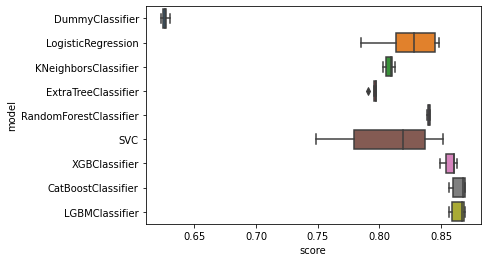

In [ ]:
sns.boxplot(data=models_df, x='score', y='model')

Ostatnie trzy (XGBoost, LigthGBM i CatBoost) dają najlepsze wyniki i pewnie warto je brać pod uwagę w przyszłości.

A czy są różnice pomiędzy transformatorami?

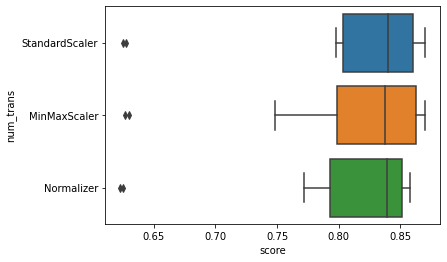

In [ ]:
sns.boxplot(data=models_df, x='score', y='num_trans')

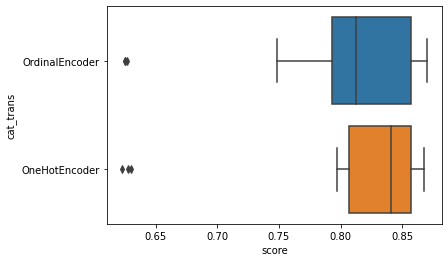

In [ ]:
sns.boxplot(data=models_df, x='score', y='cat_trans')

Przy tych danych wygląda, że właściwie nie ma większej różnicy (nie bijemy się tutaj o 0.01 punktu procentowego poprawy accuracy modelu). Może więc czas treningu jest istotny?

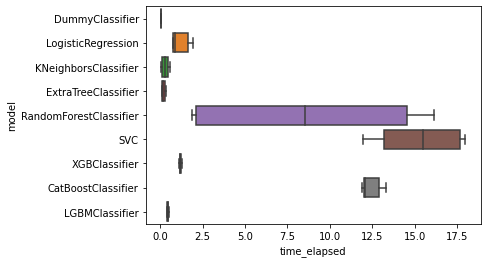

In [ ]:
sns.boxplot(data=models_df, x='time_elapsed', y='model')

Mamy kilku liderów, ale z tych które dawały najlepsze wyniki warto wziąć pod uwagę XGBoosta i LightGBM.

Dzięki przećwiczeniu kilku modeli mamy dwóch najbardziej efektywnych (czasowo) i efektownych (z najlepszym accuracy) kandydatów do dalszych prac. Wyszukanie ich to kilka linii kodu. Jeśli przyjdzie nam do głowy nowy model – dodajemy go do listy classifiers. Jeśli znajdziemy inny transformator – dopisujemy do listy scalers lub cat_transformers. Nie trzeba kopiować dużych kawałków kodu, nie trzeba właściwie pisać nowego kodu.

Dokładnie tym samym sposobem możemy poszukać hyperparametrów dla konkretnego modelu i zestawu transformacji w pipeline. Ale to już w następnym odcinku.